In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from io import StringIO
from mst_clustering import MSTClustering
from amplpy import AMPL
# warnings.filterwarnings('ignore')

In [2]:
def ampl_solve(k,m,dist):
    #generates a "Kcluster.dat" with whe data for the LP problem for AMPL to solve
    output = open("Kcluster.dat", "w")
    output.write('param k:= '+ str(k) + ';')
    output.write('\n')
    output.write('param m:= '+ str(m) + ';')
    output.write('\n')
    output.write('param d: ')
    for i in range(m):output.write(str(i + 1) + ' ')
    output.write(':=')
    output.write('\n')
    for i in range(m):
        output.write(str(i + 1) + ' ')
        for j in range(m):
            output.write(str(dist[i][j]))
            if(j != m-1):output.write(' ')
        if(i != m-1):output.write('\n')
    output.write(';')
    output.write('\n')
    output.close()
    ampl = AMPL()
    ampl.read("Kcluster.mod")
    ampl.read_data("Kcluster.dat")
    ampl.option["solver"] = "highs"

    ampl.solve()

    #AMPL solution processing
    solution_input = ampl.get_variable("x").get_values().to_pandas().values.tolist()
    solution_input[0]
    sol = [0 for _ in range(m)]
    clusters = []
    for i in range(m):
        for j in range(m):
            if solution_input[i*m + j][0] == 1:
                if not (j) in clusters: clusters.append(j)
                sol[i] = clusters.index(j)
    return sol

In [3]:
#paremeter selection

k = 5
m = 300


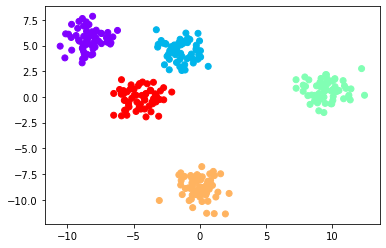

In [7]:
#generating points
random_state = 7
points, y_true = make_blobs(n_samples=m,centers = k, random_state=random_state)
plt.scatter(points[:, 0], points[:, 1],c = y_true,cmap='rainbow')


C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\moler\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are 

Text(0, 0.5, 'y')

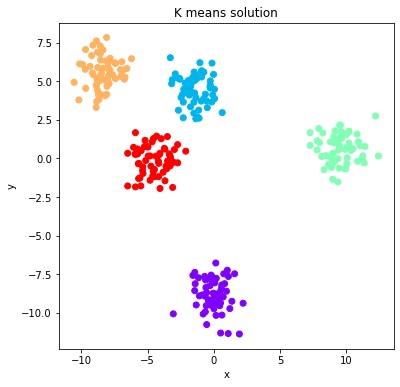

In [5]:
#Kmeans solution
random_state = 170
y_pred_kmeans = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(6, 6))


plt.scatter(points[:, 0], points[:, 1], c=y_pred_kmeans,cmap='rainbow')
plt.title("K means solution")
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

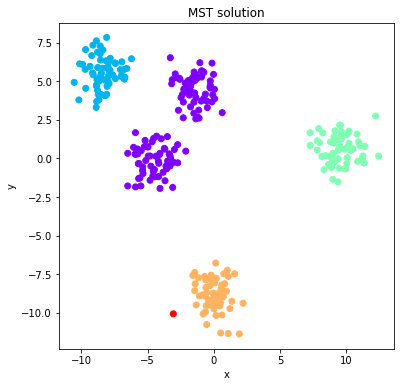

In [13]:
#MST solution
model = MSTClustering(cutoff=k-1)
y_pred_mst = model.fit_predict(points)

#print clusters
plt.figure(figsize=(6, 6))

plt.scatter(points[:, 0], points[:, 1], c=y_pred_mst, cmap='rainbow');
plt.title("MST solution")
plt.xlabel("x")
plt.ylabel("y")

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 374.384827
8081 simplex iterations
1 branching nodes
 


Text(0, 0.5, 'y')

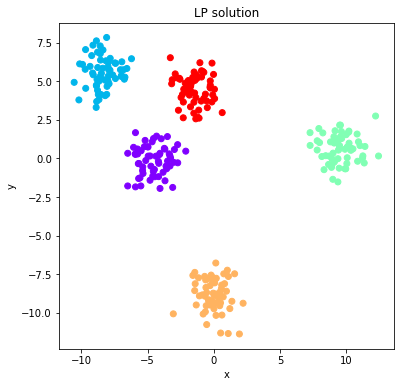

In [8]:
#AMPL solution

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]

#We solve using ampl
y_pred_ampl = ampl_solve(k,m,dist)

            
#print clusters
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c=y_pred_ampl,cmap='rainbow')
plt.title("LP solution")
plt.xlabel("x")
plt.ylabel("y")

In [20]:
#Preanalysis of the multidimensional dataset
df = pd.read_csv('wine-clustering.csv')

C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Kmeans solution')

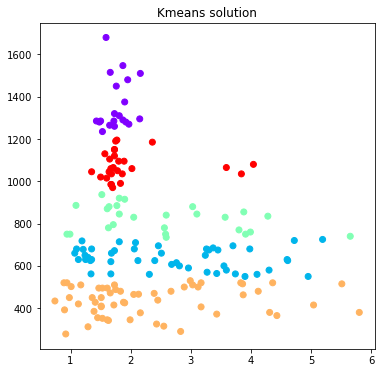

In [21]:
#Multidimensional dataset kmeans implementation

kmeans = KMeans(n_clusters=k, init='k-means++', random_state= 42)  
y_predict_kmeans= kmeans.fit_predict(df)

#print clusters
plt.figure(figsize=(6, 6))
X = df.iloc[:,1]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_predict,cmap = "rainbow");
plt.title("Kmeans solution")

Text(0.5, 1.0, 'MST solution')

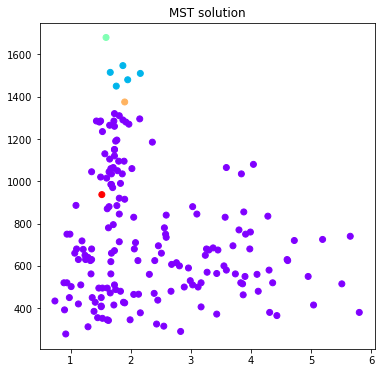

In [13]:
#Multidimensional dataset MST implementation

model = MSTClustering(cutoff=k-1)
y_predict_mst = model.fit_predict(df)

#print clusters
plt.figure(figsize=(6, 6))
X = df.iloc[:,1]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_predict_mst,cmap = "rainbow");
plt.title("MST solution")

178
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 10282.60781
6349 simplex iterations
1 branching nodes
 


Text(0.5, 1.0, 'LP solution')

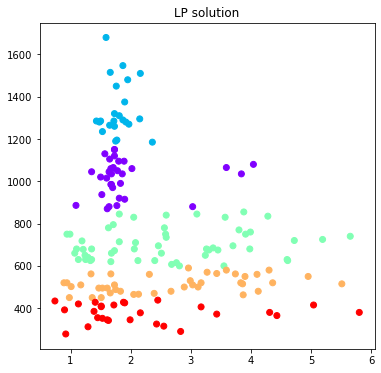

In [19]:
#Multidimensional dataset AMPL implementation

#generate matrix distance
dist = scipy.spatial.distance.pdist(df, metric='euclidean')
dist = scipy.spatial.distance.squareform(dist, force='no', checks=True)
print(len(dist))
m = df.shape[0]

#We write the generated data in a .dat AMPL format.
y_pred_ampl = ampl_solve(k,m,dist)

            
#print clusters
plt.figure(figsize=(6, 6))
X = df.iloc[:,1]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_pred_ampl,cmap = "rainbow");
plt.title("LP solution")